# Exploring and Analyzing Text Data Assignment 

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import spacy
import string
import pandas as pd
from nltk import pos_tag
from nltk.text import Text
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [3]:
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Read the CNN Lite plain text file articles into a corpus using the NLTK's PlaintextCorpusReader.

In [4]:
path = "cnn_lite/"
doc_pattern = r".*\.txt"
corpus = PlaintextCorpusReader(path, doc_pattern)

### Iterate through the fileids in the corpus, extract the raw text of each document, and store them in a list.

In [7]:
docs = [corpus.raw(id_) for id_ in corpus.fileids()]

### Write a function that calculates the following statistics for a document and returns them as a list.

- Number of sentences
- Number of tokens
- Number of words (no stop words or punctuation)
- Number of unique words (vocabulary)
- Number of unique named entities (excluding numbers, dates, times, and currency types)
- Average sentence length
- Average word length
- Lexical diversity

In [18]:
def text_stats(doc):
    sents = sent_tokenize(doc)
    tokens = word_tokenize(doc)
    words = [token.lower() for token in tokens 
             if not token.lower() in stopwords.words('english')
             if not token in string.punctuation]

    num_sents = len(sents)
    num_tokens = len(tokens)
    num_words = len(words)
    vocab = len(set(words))
    characters = sum([len(word) for word in words])
    
    spacy_doc = nlp(doc)
    remove = ['DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 
              'ORDINAL', 'CARDINAL']
    entities = [entity.text for entity in spacy_doc.ents 
                if not entity.label_ in remove]

    num_entities = len(set(entities))
    words_sent = num_words / num_sents
    try:
        char_word = characters / num_words
    except ZeroDivisionError:
        char_word = 0
    try:
        lex_div = vocab / num_words
    except ZeroDivisionError:
        lex_div = 0
    
    stats = [num_sents, num_tokens, num_words, vocab, num_entities, 
             words_sent, char_word, lex_div]

    return stats

### Iterate through all the documents, calculate these statistics for each one, and store all the results in a Pandas data frame.

In [24]:
stats = []

for i, doc in enumerate(docs):
    doc_stats = text_stats(doc)
    doc_stats = [f"Article_{i}"] + doc_stats
    stats.append(doc_stats)

### Summarize these statistics for the entire corpus by calling the Pandas `describe` method.

In [25]:
doc_df = pd.DataFrame(stats)
doc_df.columns = [
                  "Document", "Sentences", "Tokens", "Words", "Vocabulary",
                  "Entities", "Avg. Sentence Length", "Avg. Word Length",
                  "Lexical Diversity"]

doc_df.describe()

,Sentences,Tokens,Words,Vocabulary,Entities,Avg. Sentence Length,Avg. Word Length,Lexical Diversity
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,51.385965,1025.192982,542.087719,313.614035,36.122807,11.088300,6.009093,0.671872
std,69.758961,1217.950114,631.513468,259.973608,38.035730,2.439322,0.405653,0.106225
min,4.000000,30.000000,19.000000,18.000000,4.000000,4.750000,5.131579,0.351988
25%,18.000000,372.000000,197.000000,140.000000,15.000000,9.500000,5.736842,0.618750
50%,26.000000,585.000000,320.000000,209.000000,25.000000,10.615385,6.046366,0.667925
75%,63.000000,1297.000000,717.000000,429.000000,45.000000,12.887097,6.315447,0.730263
max,423.000000,7635.000000,3949.000000,1390.000000,238.000000,16.708333,6.827086,0.947368


### Choose a document from the list of documents you created earlier and generate a frequency distribution bar chart for it showing which terms appear most frequently in the text.

In [27]:
doc = docs[3]

cleaned = [
           token.lower() for token in word_tokenize(doc)
           if token.lower() not in stopwords.words("english")
           if token.isalpha()]

fdist = FreqDist(cleaned)

In [28]:
fdist_df = pd.DataFrame.from_dict(fdist, orient="index").reset_index()
fdist_df.columns = ["Term", "Freq"]
fdist_df

,Term,Freq
0,washington,1
1,cnn,3
2,meeting,6
3,oval,2
4,office,2
...,...,...
236,listen,1
237,usage,1
238,go,1
239,full,1


In [29]:
ordered_fdist = fdist_df.sort_values("Freq", ascending=False)
ordered_fdist

,Term,Freq
74,said,14
10,erdoğan,13
68,turkey,11
28,source,9
19,trump,9
...,...,...
114,give,1
116,rid,1
117,extent,1
118,understands,1


In [31]:
filtered = ordered_fdist[ordered_fdist['Freq'] > 1]
filtered

,Term,Freq
74,said,14
10,erdoğan,13
68,turkey,11
28,source,9
19,trump,9
...,...,...
135,week,2
32,first,2
166,russia,2
133,officials,2


Text(0.5, 1.0, 'Term Frequency Distribution \n')

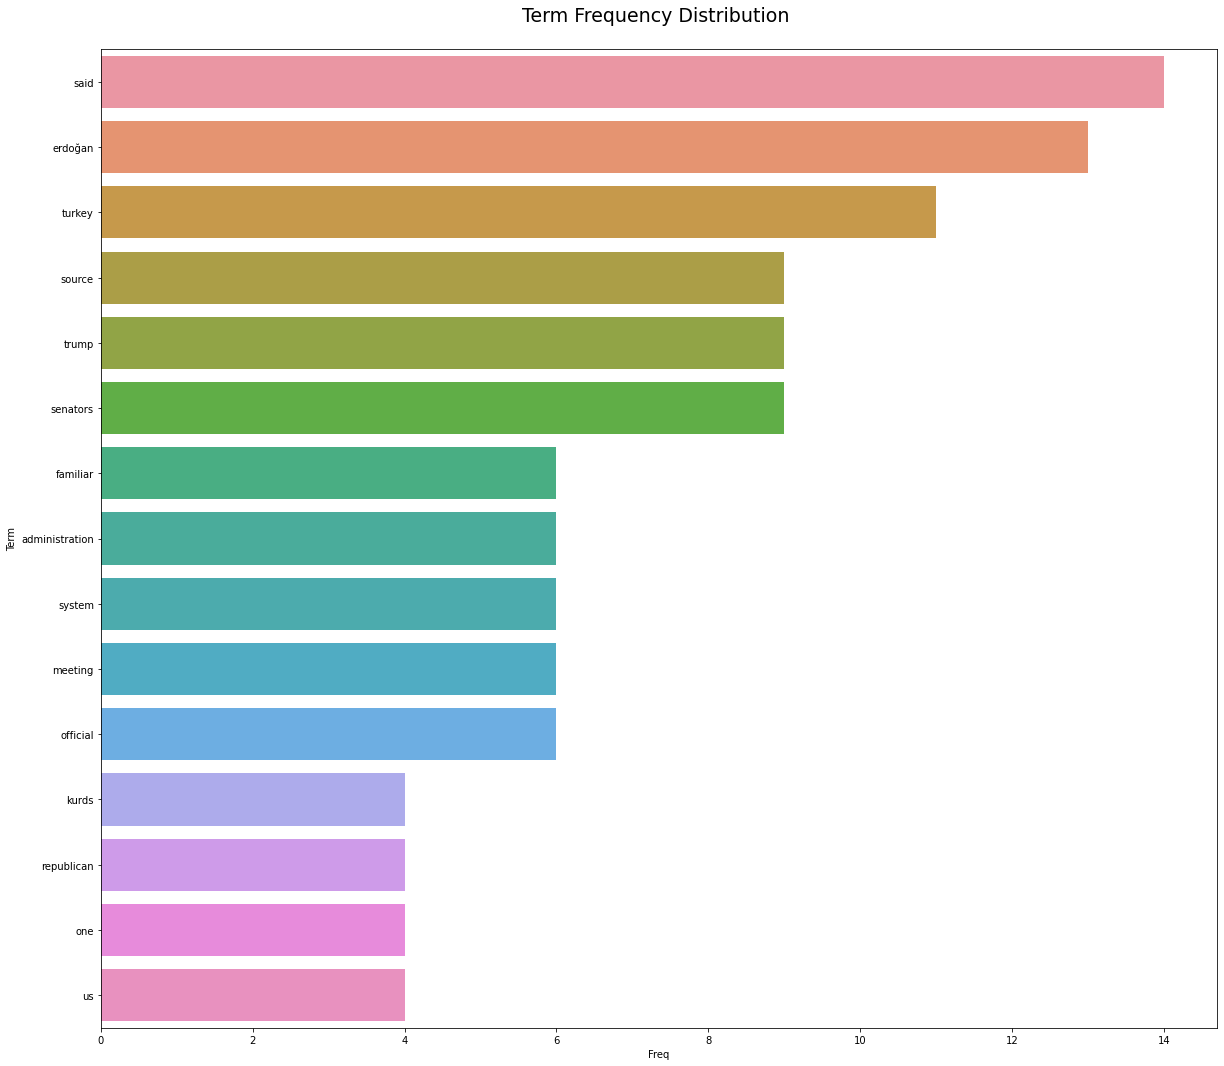

In [32]:
plt.figure(figsize=(20,18))
sns.barplot(data=filtered.head(15), x="Freq", y="Term")
plt.title("Term Frequency Distribution \n", fontsize=19)

### Generate a word cloud visualization for the same document for which you generated the frequency distribution.

In [33]:
def generate_wordcloud(text, colormap='tab10', background_color='white'):
    cloud = WordCloud(width=1600, height=900,
                      stopwords=STOPWORDS,
                      colormap=colormap,
                      background_color=background_color).generate(text)

    plt.figure(figsize=(15,12))
    plt.imshow(cloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

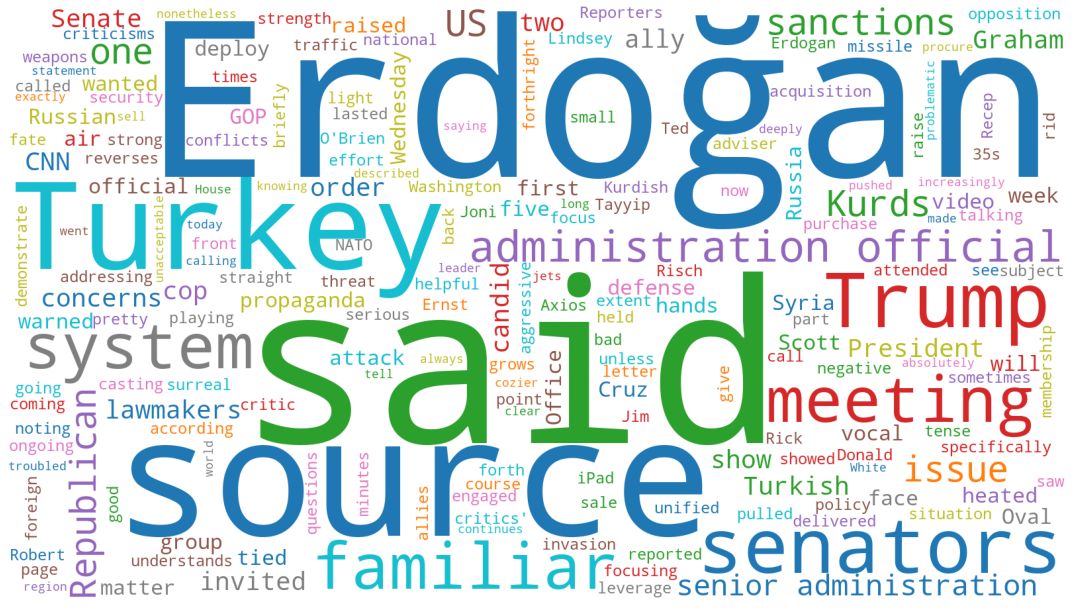

In [35]:
generate_wordcloud(doc)

### Choose a different article (preferably one that references several named entities) and create a dispersion plot that shows the occurrence of those entities throughout the document.

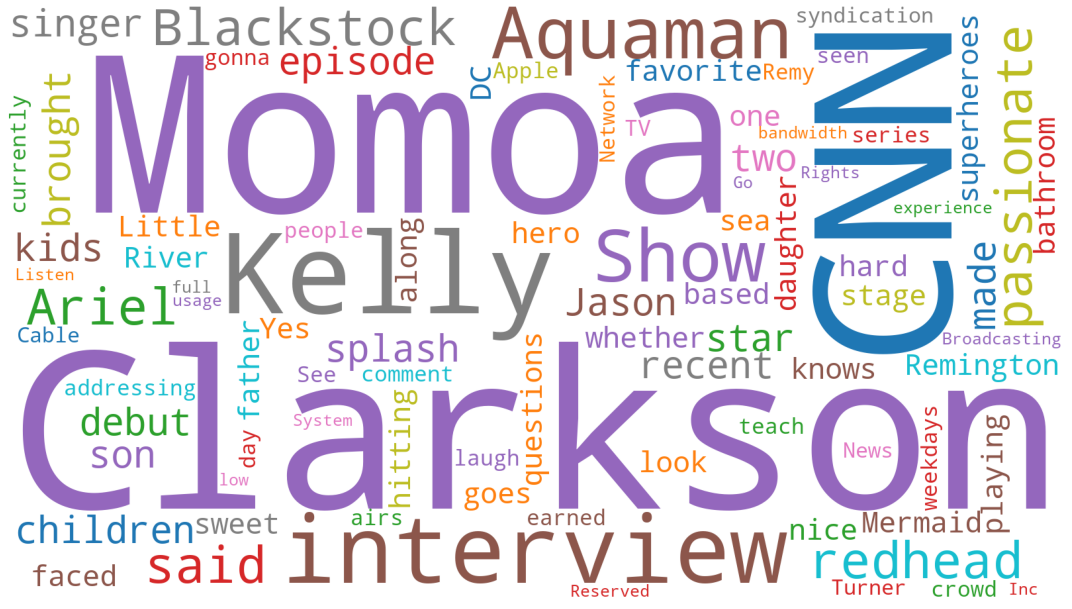

In [36]:
generate_wordcloud(docs[23])

In [37]:
from pylab import rcParams

rcParams['figure.figsize'] = 15,12

doc = docs[12]
tokenized = word_tokenize(doc)

In [42]:
unique_tokens = list(set(tokenized))

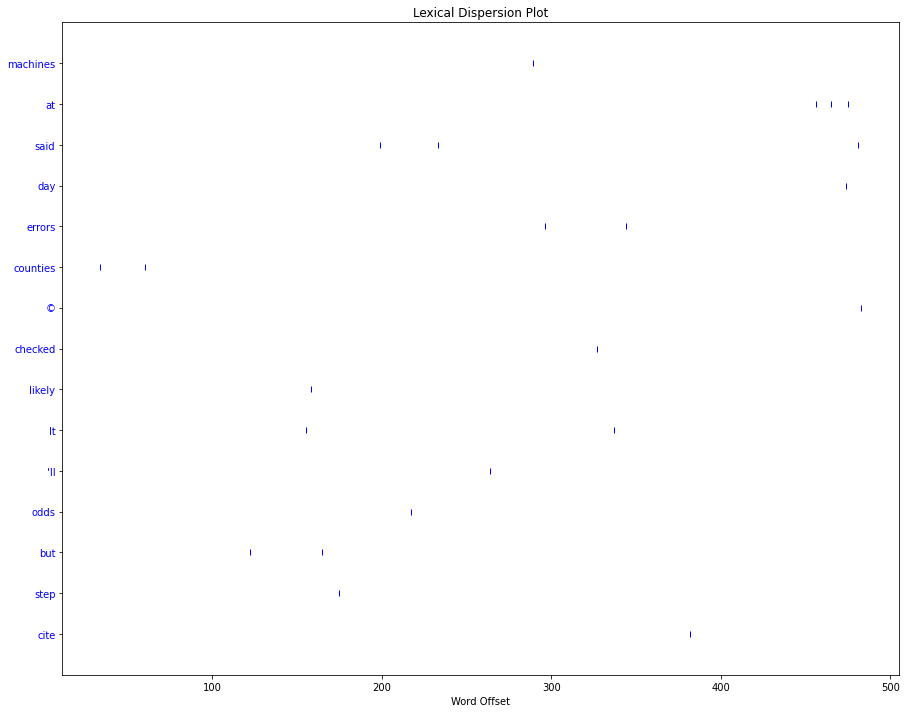

In [44]:
Text(tokenized).dispersion_plot(unique_tokens[:15])

### Choose another article and generate a POS visualization highlighting the parts of speech for tokens in the article.

In [51]:
from yellowbrick.text.postag import PosTagVisualizer

doc = docs[53]

tokens = word_tokenize(doc) 
tagged = pos_tag(tokens)

visualizer = PosTagVisualizer() 
visualizer.transform(tagged)

print(' '.join((visualizer.colorize(token, color)
                for color, token in visualizer.tagged)))

( CNN ) - A shooting has been reported at high school in Southern California , the Los Angeles County Sheriff 's Department said Thursday morning . `` Shooting at Saugus High School in Santa Clarita , '' the department said on Twitter . `` Please avoid the area . '' Students are being evacuated from the school , aerial footage from CNN affiliates shows . © 2019 Cable News Network . Turner Broadcasting System , Inc. All Rights Reserved . Listen to CNN ( low-bandwidth usage ) . Go to the full CNN experience .
